# Object pose estimation

## Overview

In this tutorial, we will showcase how to optimize the pose of an object correctly counting for the visibility discontinuities. We are going to optimize several latent variables that controls the translation and rotation of the object.

In differentiable rendering, we aim to evaluate the derivative of a pixel intensity integral with respect to a scene parameter $\pi$ as follows:
$$
\partial_\pi I(\pi) = \partial_\pi \int_P f(\textbf{x}, \pi) ~ d\textbf{x}
$$
where $\textbf{x}$ is a light path in the path space $P$. When the function $f(\cdot)$ is continuous with $\pi$, we can move the derivative into the integral and then apply Monte Carlo integration. This justifies the correctness of differentiating the entire rendering pipeline with autodiff, as is done in previous tutorials. But when the discontinuities depend on the scene parameter $\pi$, for example the silhouette of an object could move as we translate it, direct autodiff will yield biased results missing a line integral along the discontinuous boundary. 
      
In the last years, many publications addressed this issue (e.g. <cite data-cite="Loubet2019Reparameterizing">Loubet et al. (2019)</cite>, <cite data-cite="Bangaru2020">Bangaru et al. (2020)</cite>, ...). Mitsuba provides dedicated integrators that implements those algorithms to tackles this specific problem:

- [<code>prb_reparam</code>][1]: reparameterized Path Replay Backpropagation (PRB) integrator
- [<code>direct_reparam</code>][2]: reparameterized direct illumination integrator

We are going to use the `direct_reparam` as it will be sufficient for this simple example. For instance we don't need the integrator to compute higher bounce effects such as global illumination.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Perform optimization with discontinuity-aware methods</li>
  <li>Optimize latent variables to control the motion of an object</li>
</ul>
    
</div>

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb_reparam
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.direct_reparam

## Setup

As always, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## `direct_reparam` and scene construction

As stated in the intro, we will rely on the `direct_reparam` integrator for this tutorial to properly handle the visibility discontinuities in our differentiable simulation. In primal rendering, this integrator is identical to the `direct` integrator.

In [2]:
integrator = {
    'type': 'direct_reparam',
}

We create a simple scene with a bunny placed in front of a gray wall, illuminated by an spherical light.

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '../../scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]) * T.scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '../../scenes/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': '../../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]) * T.scale(0.25)
    }
})

## Reference image

Next we generate a reference image before moving the bunny to a different position.

In [4]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

## Optimizer and latent variables

As done in previous tutorial, we access the scene parameters using the `traverse()` mechanism. We then store a copy of the initial vertex positions. Those will be used later to compute the new vertex positions at every iteration, always applying a different transformation on the same base shape. 

Since the vertex positions in `Mesh` are stored in a linear buffer (e.g. `x_1, y_1, z_1, x_2, y_2, z_2, ...`), we use the `dr.unravel()` routine to unflatten that array into a `Point3f` array.

In [5]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

While it could be possible to optimize the vertex positions of the bunny independently, in this example we are only going to optimize for a translation and rotation parameter. This drastically constraints the optimization process and helps with the convergence.

For this, we instantiate an optimizer and assign two variables to it: `angle` and `trans`.

In [6]:
opt = mi.ad.Adam(lr=0.025, params=params)
opt['angle'] = mi.Float(0.25)
opt['trans'] = mi.Point2f(0.1, -0.25)

From the optimizer's point of view, those variables are the same as any other variables optimized in the previous tutorials, to the exception that when calling `opt.update()`, the optimizer doesn't know how to propagate their new values to the scene parameters. This has to be done *manually*, and we encapsulate exactly that logic in the function define here. More detailed explaination on this can be found [here][1].

After clamping the optimized variables to a proper range, this function creates a transformation object combining a translation and rotation and applies it to the vertex positions stored previously. It then flattens those new vertex positions before assigning them to the scene parameters.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/tutorials/how_to_guides/use_optimizers.html#3.-Optimize-latent-variables

In [7]:
def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    opt['angle'] = dr.clamp(opt['angle'], -0.5, 0.5)
    
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0]) * \
            mi.Transform4f.rotate([0, 1, 0], opt['angle'] * 100.0)
    
    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)

It is now time to apply our first transformation to get the bunny to its initial position before starting the optimization.

In [8]:
apply_transformation(params, opt)

opt.update()

img_init = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

The optimization loop written below is very similar to the one used in the other tutorials, except that we need to apply the transformation after taking a gradient step at every iterations.

In [9]:
loss_hist = []
for it in range(50):
    img = mi.render(scene, params, seed=it, spp=16)
    
    loss = dr.hsum_async(dr.sqr(img - img_ref)) / len(img)
    
    dr.backward(loss)

    opt.step()
    
    apply_transformation(params, opt)

    opt.update()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]", end='\r')

## Visualize the results

Finally, let's visualize the results and plot the loss over iterations

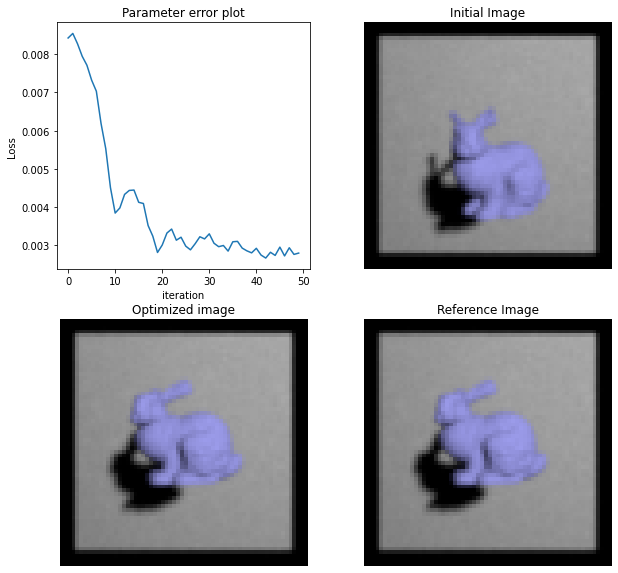

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

## See also

- [Detailed look at Optimizer](https://mitsuba3.readthedocs.io/en/latest/src/tutorials/how_to_guides/use_optimizers.html)
- [<code>mitsuba.ad.Optimizer</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
- [<code>mitsuba.ad.integrators.prb_reparam</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb_reparam)
- [<code>mitsuba.ad.integrators.direct_reparam</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.direct_reparam)